###1. 라이브러리 불러오기

In [ ]:
import os
import shutil
from torch.utils.data import DataLoader
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms

# Visualization
import cv2
import matplotlib.pyplot as plt
from torchsummary import summary

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


###2. 데이터셋 정의 - 비오염

In [ ]:
# Data loading and transformations
transform = transforms.Compose([
  transforms.RandomHorizontalFlip(),
  transforms.RandomCrop(32, padding=4),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
# Use PyTorch's torchvision.transforms.ToTenesor() to convert the dataset to tensor format
train_set = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = CIFAR10(root='./data', train=False, download=True, transform=transform)

100%|██████████| 170M/170M [00:02<00:00, 56.9MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# Use PyTorch's DataLoader to divide the dataset into mini-batches and load the data
train_loader = DataLoader(dataset=train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=64, shuffle=False)

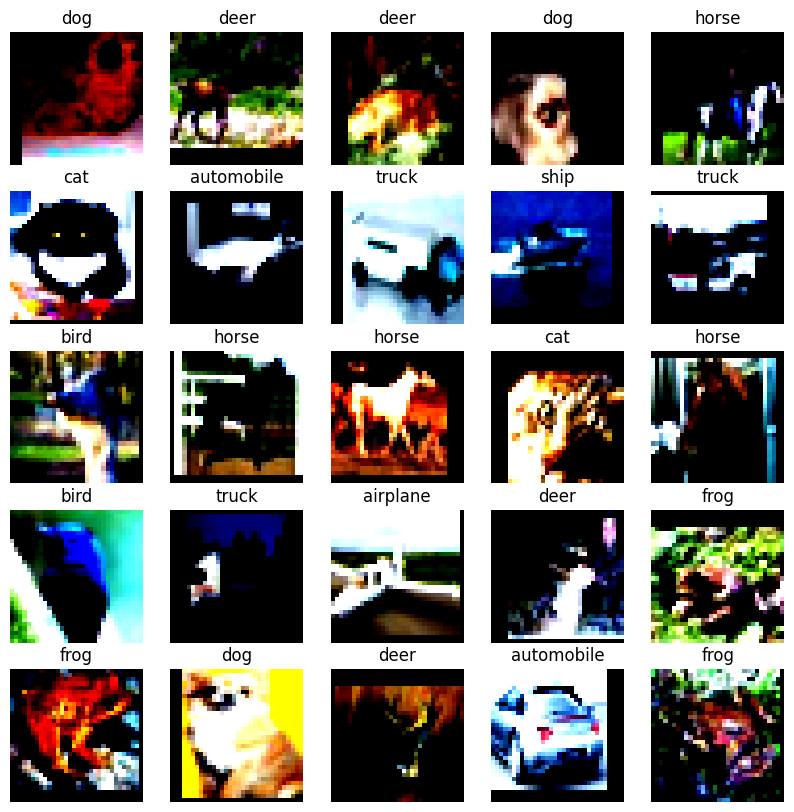

In [ ]:
# Visualization of train dataset samples
import matplotlib.pyplot as plt

classes = train_set.classes

batch = next(iter(train_loader))
images, labels = batch

grid_img = torchvision.utils.make_grid(images[:25], nrow=5, padding=5)

# Display titles below each image
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].permute(1, 2, 0))  # Permute dimensions for matplotlib (C, H, W) -> (H, W, C)
    plt.title(classes[labels[i]])
    plt.axis('off')
plt.show()

###3. 신경망 코딩 - ResNet50

In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

NameError: name 'nn' is not defined

In [ ]:
# ResNet50 모델 신경망 생성 및 장치에 저장
model_res = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10).to(device)

###4. 신경망 학습과 테스트 진행

In [ ]:
# Evaluate function
def evaluate(model, device, test_loader):
  model.eval()
  total_correct = 0
  with torch.no_grad():
     for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      _, preds = torch.max(output, 1)
      total_correct += (preds == target).sum().item()

  accuracy = 100 * total_correct / len(test_loader.dataset)
  return accuracy

In [ ]:
# Train and evaluate function
def train_and_evaluate(model, device, train_loader, test_loader, epochs=5):
  model.train()

  criterion = nn.CrossEntropyLoss()
  # optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
  optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9, weight_decay=1e-4)

  accuracies = []

  for epoch in range(epochs):
    running_loss = 0.0
    data_iterator = iter(train_loader)
    for inputs, labels in data_iterator:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'[Epoch {epoch + 1}] loss: {running_loss / len(train_loader):.3f}')

    accuracy = evaluate(model, device, test_loader)
    accuracies.append(accuracy)
    print(f'Accuracy: {accuracy:.2f}%')

  return accuracies

In [ ]:
acc_res = train_and_evaluate(model_res, device, train_loader, test_loader, epochs=5)

[Epoch 1] loss: 1.550
Accuracy: 51.95%
[Epoch 2] loss: 1.575
Accuracy: 57.84%
[Epoch 3] loss: 1.118
Accuracy: 64.75%
[Epoch 4] loss: 0.948
Accuracy: 67.69%
[Epoch 5] loss: 0.824
Accuracy: 73.70%


###데이터의 오염을 통한 학습 효율 변화

In [ ]:
#데이터 오염 함수 정의
import random

# Label 오염을 10%의 샘플에 적용하는 함수 정의
def crazy_label(dataset, attack_ratio=0.1):
    """
    CIFAR-10 데이터셋의 일부 샘플에 Label오염을 가하는 함수입니다.

    Args:
    - dataset: CIFAR-10 데이터셋 객체
    - attack_ratio: 공격할 이미지 비율 (0.1 = 10%)

    Returns:
    - attacked_dataset: 공격이 적용된 새로운 CIFAR-10 데이터셋 (TensorDataset)
    """
    # 전체 이미지와 라벨을 저장할 리스트
    attacked_images = []
    attacked_labels = []

    # 전체 데이터셋의 attack_ratio 비율만큼 공격할 샘플 수 계산
    num_attack_samples = int(attack_ratio * len(dataset))
    attacked_indices = random.sample(range(len(dataset)), num_attack_samples)  # 무작위 인덱스 선택

    for idx in range(len(dataset)):
        # 이미지와 라벨을 가져오기
        image, label = dataset[idx]

        if idx in attacked_indices:
            # 라벨 복사 후 공격 수행
            original_label = label
            passco = False

            # 원래 라벨을 제외한 랜덤으로 라벨 설정
            while passco == False:
              label = random.randrange(1, 10)

              passco = True
              if label == original_label:
                passco = False
            # 공격하지 않은 이미지는 원본을 그대로 사용
            attacked_images.append(image)
            attacked_labels.append(label)
            attacked_images.append(image)
            attacked_labels.append(original_label)
        else:
        # 리스트에 추가
            attacked_images.append(image)
            attacked_labels.append(label)

    # 리스트를 텐서로 변환
    attacked_images_tensor = torch.stack(attacked_images)
    attacked_labels_tensor = torch.tensor(attacked_labels)

    # TensorDataset으로 묶어 새로운 데이터셋 반환
    attacked_dataset = TensorDataset(attacked_images_tensor, attacked_labels_tensor)
    return attacked_dataset

In [ ]:
train_set_op = crazy_label(train_set, attack_ratio=0.1)

# DataLoader를 통해 배치 단위로 로드 가능
train_loader_op = DataLoader(dataset = train_set_op, batch_size=64, shuffle=True)

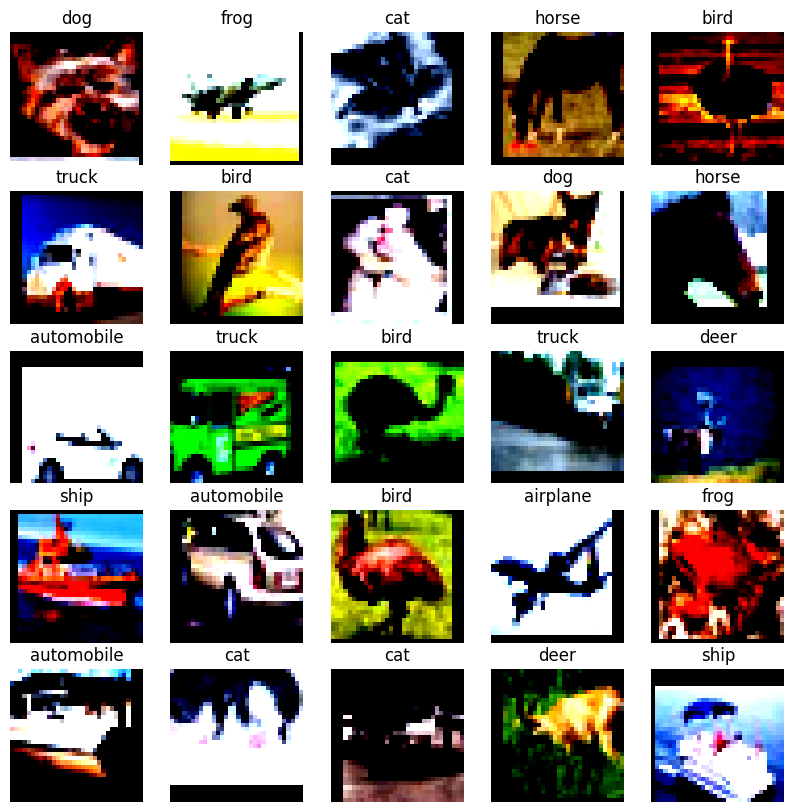

In [ ]:
# Visualization of train dataset samples
import matplotlib.pyplot as plt

classes = train_set.classes

batch = next(iter(train_loader_op))
images, labels = batch

grid_img = torchvision.utils.make_grid(images[:25], nrow=5, padding=5)

# Display titles below each image
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].permute(1, 2, 0))  # Permute dimensions for matplotlib (C, H, W) -> (H, W, C)
    plt.title(classes[labels[i]])
    plt.axis('off')
plt.show()

In [ ]:
#초기 신경망 생성 및 장치에 저장
model_res_c = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10).to(device)

In [ ]:
acc_res_op = train_and_evaluate(model_res_c, device, train_loader_op, test_loader, epochs=5)

[Epoch 1] loss: 1.777
Accuracy: 50.11%
[Epoch 2] loss: 1.479
Accuracy: 58.91%
[Epoch 3] loss: 1.288
Accuracy: 65.50%
[Epoch 4] loss: 1.167
Accuracy: 70.32%
[Epoch 5] loss: 1.066
Accuracy: 74.54%


###오염된 양 증가

In [ ]:
train_set_20 = crazy_label(train_set, attack_ratio=0.2)
train_loader_20 = DataLoader(dataset = train_set_20, batch_size=64, shuffle=True)

train_set_40 = crazy_label(train_set, attack_ratio=0.4)
train_loader_40 = DataLoader(dataset = train_set_40, batch_size=64, shuffle=True)

train_set_60 = crazy_label(train_set, attack_ratio=0.6)
train_loader_60 = DataLoader(dataset = train_set_60, batch_size=64, shuffle=True)

In [ ]:
#초기 신경망 생성 및 장치에 저장
model_res_20 = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10).to(device)
model_res_40 = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10).to(device)
model_res_60 = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10).to(device)

In [ ]:
acc_res_20 = train_and_evaluate(model_res_20, device, train_loader_20, test_loader, epochs=5)

[Epoch 1] loss: 1.912
Accuracy: 46.19%
[Epoch 2] loss: 1.685
Accuracy: 57.15%
[Epoch 3] loss: 1.527
Accuracy: 64.15%
[Epoch 4] loss: 1.424
Accuracy: 67.17%
[Epoch 5] loss: 1.336
Accuracy: 70.13%


In [ ]:
acc_res_40 = train_and_evaluate(model_res_40, device, train_loader_40, test_loader, epochs=5)

[Epoch 1] loss: 2.027
Accuracy: 48.55%
[Epoch 2] loss: 1.856
Accuracy: 56.34%
[Epoch 3] loss: 1.748
Accuracy: 62.16%
[Epoch 4] loss: 1.675
Accuracy: 67.47%
[Epoch 5] loss: 1.612
Accuracy: 69.88%


In [ ]:
acc_res_60 = train_and_evaluate(model_res_60, device, train_loader_60, test_loader, epochs=5)

[Epoch 1] loss: 2.122
Accuracy: 46.18%
[Epoch 2] loss: 1.975
Accuracy: 55.45%
[Epoch 3] loss: 1.885
Accuracy: 62.38%
[Epoch 4] loss: 1.827
Accuracy: 67.00%
[Epoch 5] loss: 1.783
Accuracy: 69.04%


###최종 비교 그래프

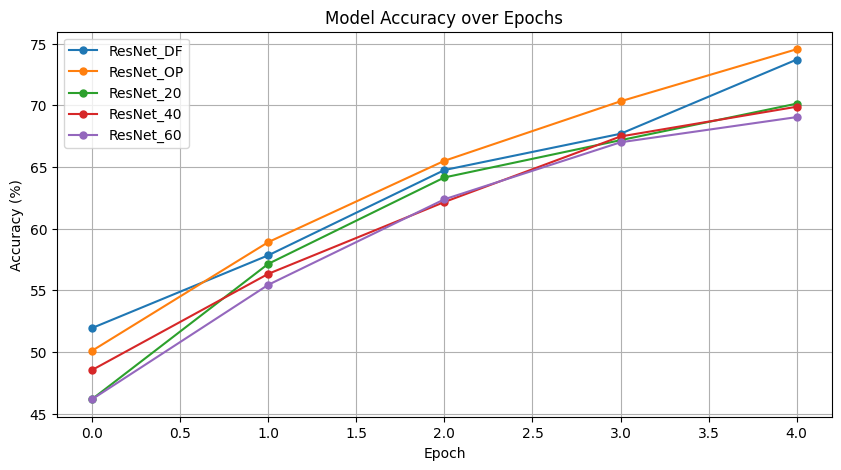

In [ ]:
# Visualize the test accuracy
plt.figure(figsize=(10, 5))

plt.plot(acc_res, marker='o', linestyle='-', markersize=5, label='ResNet_DF')
plt.plot(acc_res_op, marker='o', linestyle='-', markersize=5, label='ResNet_OP')
plt.plot(acc_res_20, marker='o', linestyle='-', markersize=5, label='ResNet_20')
plt.plot(acc_res_40, marker='o', linestyle='-', markersize=5, label='ResNet_40')
plt.plot(acc_res_60, marker='o', linestyle='-', markersize=5, label='ResNet_60')

plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.grid(True)
plt.legend()
plt.show()

결론: ResNet50에 대한 공격 효용성이 매우 강함

In [ ]:
# Random Label 알고리즘 검증용
train_set_all = crazy_label(train_set, attack_ratio=1)
train_loader_all = DataLoader(dataset = train_set_all, batch_size=64, shuffle=True)

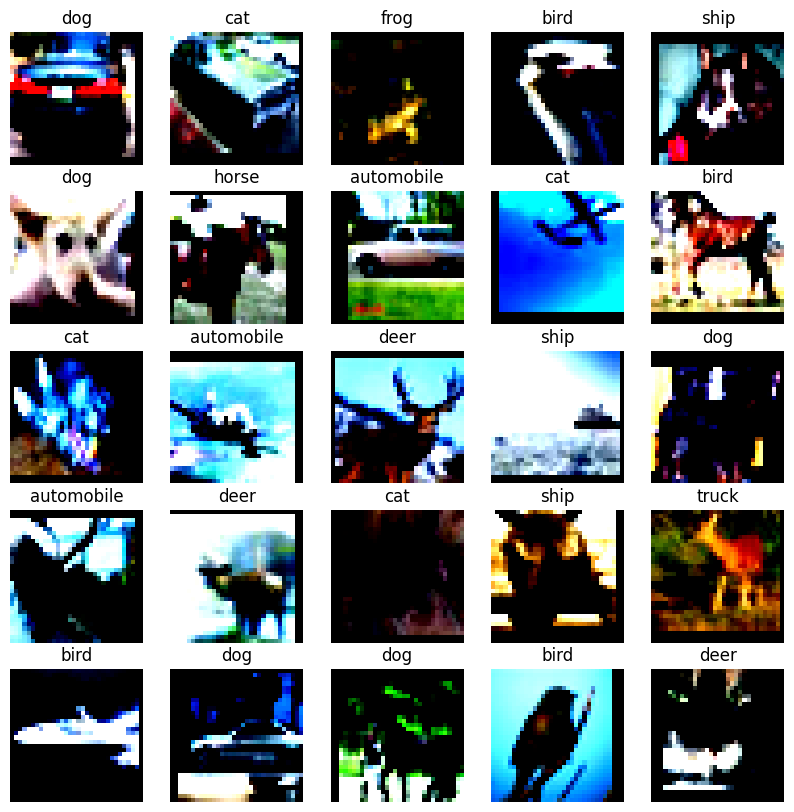

In [ ]:
# Visualization of train dataset samples
import matplotlib.pyplot as plt

classes = train_set.classes

batch = next(iter(train_loader_all))
images, labels = batch

grid_img = torchvision.utils.make_grid(images[:25], nrow=5, padding=5)

# Display titles below each image
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].permute(1, 2, 0))  # Permute dimensions for matplotlib (C, H, W) -> (H, W, C)
    plt.title(classes[labels[i]])
    plt.axis('off')
plt.show()